# Example of Track Reconstruction from Graph Output

In [4]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml
import logging

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch_geometric
from scipy import sparse as sps

# import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import wandb

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../../..")

from notebooks.ITk.utils import *
from onetrack import TrackingData
from onetrack.file_utils import list_files
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Roadmap

1. Read in scored graphs
2. Convert it to the more flexible `TrackingData` dataset
    - `TrackingData` needs to be able to `add_scored_graphs`
    - Needs to check type; if PyG `Data` type, then convert to numpy under the hood
    - Needs to read event files; if `event_attribute` is not None, then read on conversion and assign to `Event` object
3. Add `track_candidates` in `Graph`
    - Start with a single `Candidates` per `Event`
    - Across `TrackingData` build all `track_candidates`
    - Within `Graph` apply score cut
    - Apply candidate building method
    - Apply any post-processing (e.g. cleaning)
4. Add `evaluate` method to `Candidates`
    - Produces an `Evaluation` object - start with a single object per candidate
    - Can be used to produce plots
    - Can be called directly to get metrics
    - Requires method input
5. Add `evaluate` method to `TrackingData`
6. Add `plot` method to `TrackingData`
7. May need to have a plug-and-play object for `Readers`, especially to process e.g. pT depending on the event style
8. May need to have a plug-and-play object for `TrackBuilders`
9. OR just inherit from `TrackingData`? No, that's going to be messy since you need to then override all subsequent objects. Maybe a better way to do all this...

    

## Implementation

In [5]:
# Read yaml config 
with open("tracking_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [16]:
# Load in files
files = list_files(os.path.join(config["graph_input_dir"], "train"))[:100]

In [7]:
sample = torch.load(files[0], map_location="cpu")

In [17]:
# Build TrackingData object
tracking_data = TrackingData(files)

INFO:root:Loading files


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Building events


  0%|          | 0/100 [00:00<?, ?it/s]

## Example usage

Sanity check the graph:

In [9]:
tracking_data.build_candidates(building_method="CC", sanity_check=True)

INFO:root:Building candidates with sanity check: True


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
tracking_data.evaluate_candidates(evaluation_method="matching")

INFO:root:Evaluating candidates


  0%|          | 0/10 [00:00<?, ?it/s]

{'building_method': 'CC', 'evaluation_method': 'matching', 'eff': 0.9780466386964581, 'single_eff': 0.978729632159235, 'fr': 8.520790729382721e-05, 'dup': 0.14579072937968643}
n_true_tracks: 10249, n_reco_tracks: 11736, n_matched_particles: 10024, n_matched_tracks: 11735, n_duplicated_tracks: 1711


Now run real pipeline:

In [18]:
tracking_data.build_candidates(building_method="CC", score_cut = 0.85)

INFO:root:Building candidates with sanity check: False


  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
matching_config = {
    "min_hits_truth": 3,
    "min_hits_reco": 3,
    "frac_reco_matched": 0.5,
    "frac_truth_matched": 0.5,
}

In [26]:
tracking_data.evaluate_candidates(evaluation_method="matching", **matching_config)

INFO:root:Evaluating candidates


  0%|          | 0/100 [00:00<?, ?it/s]

{'building_method': 'CC', 'evaluation_method': 'matching', 'eff': 0.915290962461468, 'single_eff': 0.9213170783558597, 'fr': 0.012348425055607404, 'dup': 0.048579321231254934}
n_true_tracks: 122301, n_reco_tracks: 278740, n_matched_particles: 111941, n_matched_tracks: 275298, n_duplicated_tracks: 13541


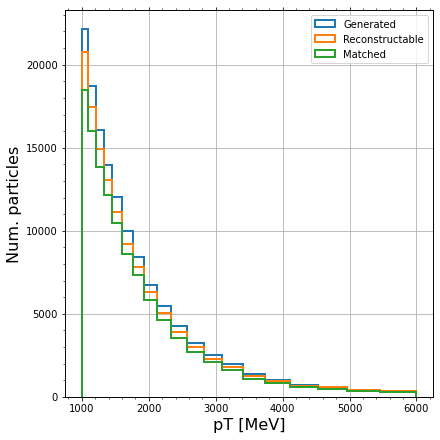

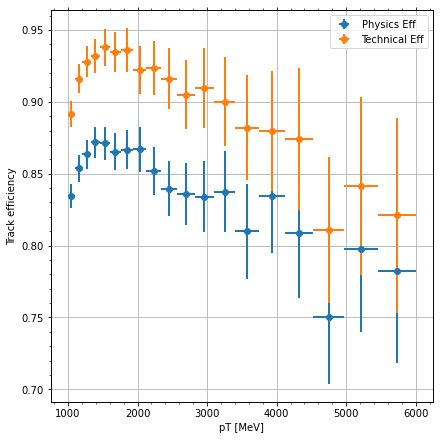

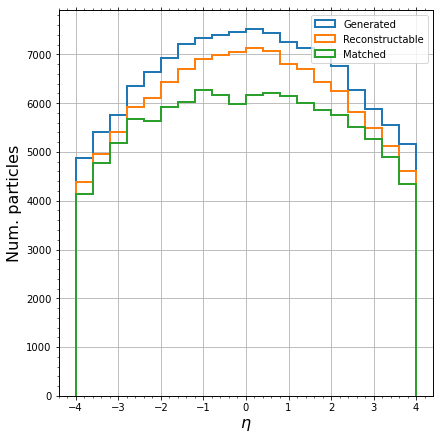

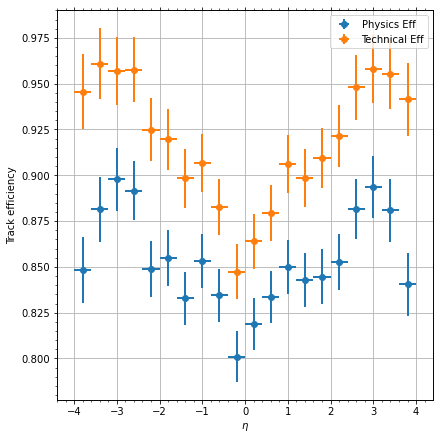

In [27]:
tracking_data.plot_evaluation()